# Apply Pseudo Labelling to best TPOT Model in the Instant Gratification Competition
Code of this notebook is borrowed from  [Pseudo Labeling - QDA - [0.969]](https://www.kaggle.com/cdeotte/pseudo-labeling-qda-0-969). Thanks to Chris for his work. We search the best model for the first 'wheezy-copper-turtle-magic' chunck of train dataset then apply it to the whole problem. Only a small number of iterations is performed to demonstrate the workflow. 
## Load Data

In [1]:
import numpy as np, pandas as pd, os
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
from tpot import TPOTClassifier
from tqdm import tqdm 
from warnings import simplefilter
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


simplefilter(action='ignore', category=FutureWarning)


train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

## Step 1: Find the best TPOT Model

In [2]:
%%time
cols = [c for c in train.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')
oof = np.zeros(len(train))
preds = np.zeros(len(test))

# ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS 0
# Change i to choose another group of train data
i=0
train2 = train[train['wheezy-copper-turtle-magic']==i]
test2 = test[test['wheezy-copper-turtle-magic']==i]
idx1 = train2.index; idx2 = test2.index
train2.reset_index(drop=True,inplace=True)

# FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
train3 = sel.transform(train2[cols])
test3 = sel.transform(test2[cols])
  
#Change generations and population_size to find better pipelines
# Visit http://epistasislab.github.io/tpot/api/ for the API documentation
tpot = TPOTClassifier(generations=50, population_size=30, verbosity=2, scoring='roc_auc', cv=3, max_eval_time_mins=1, random_state=42, n_jobs=-1)
tpot.fit(train3,  train2['target'])

Generation 1 - Current best internal CV score: 0.8730429851119507
Generation 2 - Current best internal CV score: 0.9112851654518321
Generation 3 - Current best internal CV score: 0.9112851654518321
Generation 4 - Current best internal CV score: 0.9112851654518321
Generation 5 - Current best internal CV score: 0.9112851654518321
Generation 6 - Current best internal CV score: 0.9112851654518321
Generation 7 - Current best internal CV score: 0.9112851654518321
Generation 8 - Current best internal CV score: 0.9112851654518321
Generation 9 - Current best internal CV score: 0.9221626181396297
Generation 10 - Current best internal CV score: 0.9221626181396297
Generation 11 - Current best internal CV score: 0.9238439880681261
Generation 12 - Current best internal CV score: 0.936236788966674
Generation 13 - Current best internal CV score: 0.936236788966674
Generation 14 - Current best internal CV score: 0.936236788966674
Generation 15 - Current best internal CV score: 0.936236788966674
Generati

## Step 2 - Fit the TPOT model and predict on test

In [3]:
%%time
# INITIALIZE VARIABLES
cols = [c for c in train.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')
oof = np.zeros(len(train))
preds = np.zeros(len(test))

# BUILD 512 SEPARATE MODELS
for i in tqdm(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
    
    # STRATIFIED K-FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3, train2['target']):
        
        # MODEL AND PREDICT WITH TPOT best fitted pipeline
        tpot.fitted_pipeline_.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof[idx1[test_index]] = tpot.fitted_pipeline_.predict_proba(train3[test_index,:])[:,1]
        preds[idx2] += tpot.fitted_pipeline_.predict_proba(test3)[:,1] / skf.n_splits
       
        
# PRINT CV AUC
auc = roc_auc_score(train['target'],oof)
print('TPOT scores CV =',round(auc,5))

100%|██████████| 512/512 [13:45<00:00,  1.56s/it]

TPOT scores CV = 0.95831
CPU times: user 19min 45s, sys: 34min 44s, total: 54min 29s
Wall time: 13min 45s


## Step 3 & 4 - Add pseudo label data and build QDA model 

In [4]:
%%time
# INITIALIZE VARIABLES
test['target'] = preds
oof = np.zeros(len(train))
preds = np.zeros(len(test))

# BUILD 512 SEPARATE MODELS
for k in tqdm(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==k] 
    train2p = train2.copy(); idx1 = train2.index 
    test2 = test[test['wheezy-copper-turtle-magic']==k]
    
    # ADD PSEUDO LABELED DATA
    test2p = test2[ (test2['target']<=0.01) | (test2['target']>=0.99) ].copy()
    test2p.loc[ test2p['target']>=0.5, 'target' ] = 1
    test2p.loc[ test2p['target']<0.5, 'target' ] = 0 
    train2p = pd.concat([train2p,test2p],axis=0)
    train2p.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2p[cols])     
    train3p = sel.transform(train2p[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
        
    # STRATIFIED K FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3p, train2p['target']):
        test_index3 = test_index[ test_index<len(train3) ] # ignore pseudo in oof
        
        # MODEL AND PREDICT WITH QDA
        clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
        clf.fit(train3p[train_index,:],train2p.loc[train_index]['target'])
        oof[idx1[test_index3]] = clf.predict_proba(train3[test_index3,:])[:,1]
        preds[test2.index] += clf.predict_proba(test3)[:,1] / skf.n_splits
               
# PRINT CV AUC
auc = roc_auc_score(train['target'],oof)
print('QDA scores CV =',round(auc,5))

100%|██████████| 512/512 [00:58<00:00,  8.81it/s]


QDA scores CV = 0.96567
CPU times: user 1min 21s, sys: 2min 27s, total: 3min 49s
Wall time: 58.3 s


## Submit Predictions

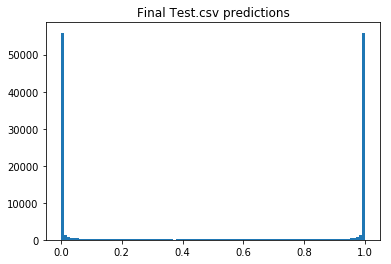

In [5]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = preds
sub.to_csv('submission.csv',index=False)

import matplotlib.pyplot as plt
plt.hist(preds,bins=100)
plt.title('Final Test.csv predictions')
plt.show()